# Atividade: GANs

Neste notebook, você irá **preparar seu próprio dataset** e **treinar uma DCGAN utilizando a distância de Wasserstein**.
O objetivo é gerar imagens sintéticas a partir de ruído, aprendendo a distribuição dos dados reais.

O treinamento será realizado com um **Gerador** e um **Crítico** (substituindo o discriminador tradicional), aplicando **gradient clipping** para garantir a restrição de Lipschitz exigida pela métrica de Wasserstein.

Ao final, o modelo deverá ser capaz de **produzir imagens realistas** a partir de vetores aleatórios.

## Preparando os dados

Para esta atividade, será necessário baixar ou montar um dataset de imagens de um domínio específico (por exemplo, rostos, paisagens, objetos, etc.). Você pode utilizar datasets públicos como LFW e CelebA ou criar o seu próprio conjunto de imagens armazenadas em uma pasta local.

### Coleta de Imagens

Caso opte por montar seu próprio dataset, você pode utilizar a biblioteca iCrawler para baixar imagens automaticamente a partir de buscadores (como Google, Bing ou Baidu), fornecendo uma lista de termos relacionados ao domínio desejado.

Segue o link para o dataset utilizado: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset?select=images

A raça escolhida foi a pug.

### Implementação do Dataset

Com as imagens já disponíveis, implemente uma **classe de Dataset personalizada** para o PyTorch. Ela deve herdar de `Dataset` e retornar, em cada amostra, a imagem processada pelos **transforms** definidos anteriormente.

O Dataset deve:

* Ler as imagens a partir de uma pasta.
* Converter as imagens para **tensor normalizado** (ex.: valores entre -1 e 1).

In [53]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.images = [
            os.path.join(folder, f)
            for f in os.listdir(folder)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

### Carregamento

Carregue os dados a partir do seu dataset de imagens e aplique os transforms necessários. Caso o dataset seja pequeno, recomenda-se o uso de data augmentation (como flips horizontais, jitter de cor ou pequenas rotações) para aumentar a diversidade das amostras e melhorar a estabilidade do treinamento adversarial. Em seguida, defina um batch size adequado e instancie um DataLoader.

In [54]:
import torchvision.transforms as T

transform = T.Compose([
    T.Resize((64, 64)),
    # Caso tenha poucas imagens, adicione data augmentation aqui
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = ImageDataset(f"data/pug", transform)
train_loader = DataLoader(train_dataset)

## Definição dos Modelos

Para este exercício, deverão ser utilizadas DCGANs com distância de Wasserstein. Nesta seção, defina a arquitetura dos modelos Gerador e Crítico, implementando o treinamento adversarial baseado na métrica de Wasserstein.

### Gerador

O Gerador seguirá a arquitetura típica de uma DCGAN, produzindo amostras sintéticas a partir de vetores de ruído, enquanto o Crítico avaliará a distância entre as distribuições reais e geradas.

In [55]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, ngf=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (img_channels) x 64 x 64
        )

        # Initialize weights
        self.apply(self._weights_init)

    def _weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def forward(self, input):
        return self.main(input)

print("Generator model class defined.")

Generator model class defined.


### Crítico

O Crítico (substituindo o discriminador tradicional) deve utilizar gradient clipping para garantir o cumprimento da restrição de Lipschitz, condição essencial para a estabilidade da função de custo de Wasserstein.

In [56]:
class Critic(nn.Module):
    def __init__(self, img_channels, ndf=64):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            # input is (img_channels) x 64 x 64
            nn.Conv2d(img_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
            # state size. 1 x 1 x 1
        )

        # Initialize weights
        self.apply(self._weights_init)

    def _weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def forward(self, input):
        return self.main(input)

print("Critic model class defined.")

Critic model class defined.


## Treinamento

Com o **Gerador** e o **Crítico** definidos, e os dados devidamente carregados, inicie o treinamento.

Durante o processo:

* Atualize o **Crítico** várias vezes para cada atualização do **Gerador**, garantindo uma estimativa mais precisa da distância de Wasserstein.
* Aplique **gradient clipping** nos parâmetros do Crítico após cada atualização, mantendo a restrição de **Lipschitz**.
* Utilize **losses baseadas na métrica de Wasserstein**.

Ao longo do treinamento, **visualize amostras geradas** a cada determinado número de épocas, observando a evolução da qualidade das imagens produzidas pelo Gerador.

In [57]:
#Definição dos Hiperparâmetros
num_epochs = 10
lr = 5e-05 # Current learning rate
critic_iterations = 5 # Current critic iterations
b_size = 64 # Changed from 1 to 64 for faster training

print(f"num_epochs set to: {num_epochs}")
print(f"lr (learning rate) set to: {lr}")
print(f"critic_iterations set to: {critic_iterations}")
print(f"b_size (batch size) set to: {b_size}")

num_epochs set to: 10
lr (learning rate) set to: 5e-05
critic_iterations set to: 5
b_size (batch size) set to: 64


In [58]:
#Inicialização
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model parameters (already in kernel state but for clarity)
z_dim = 100
img_channels = 3

# Instantiate Generator and Critic
netG = Generator(z_dim, img_channels).to(device)
netC = Critic(img_channels).to(device)

# Setup Adam optimizers for both G and C
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerC = optim.Adam(netC.parameters(), lr=lr, betas=(0.5, 0.999))

# Fixed noise for visualization
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

print("Generator, Critic, Optimizers, and fixed noise initialized.")

Using device: cpu
Generator, Critic, Optimizers, and fixed noise initialized.


In [59]:
import tqdm
import numpy as np # Import numpy for mean calculation

# Training Loop

# Lists to keep track of progress (per epoch average)
gen_losses = []
critic_losses = []
# To store generated images for visualization (one per epoch)
img_list = []

print("Starting Training Loop...")
for epoch in range(num_epochs):
    epoch_gen_losses = []
    epoch_critic_losses = []

    # For each batch in the dataloader
    for i, data in enumerate(tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):

        # (1) Update Critic network: maximize D(x) - D(G(z))
        for _ in range(critic_iterations):
            netC.zero_grad()
            # Format batch
            real_cpu = data.to(device)
            b_size_current = real_cpu.size(0)

            # Train with all-real batch
            critic_real = netC(real_cpu).view(-1)
            errC_real = -critic_real.mean()
            errC_real.backward()

            # Train with all-fake batch
            noise = torch.randn(b_size_current, z_dim, 1, 1, device=device)
            fake = netG(noise).detach() # Detach to prevent G from updating
            critic_fake = netC(fake).view(-1)
            errC_fake = critic_fake.mean()
            errC_fake.backward()

            errC = errC_real + errC_fake
            optimizerC.step()

            # Gradient clipping for Critic
            for p in netC.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # (2) Update Generator network: maximize D(G(z))
        netG.zero_grad()
        noise = torch.randn(b_size_current, z_dim, 1, 1, device=device)
        fake = netG(noise)
        output = netC(fake).view(-1)
        errG = -output.mean()
        errG.backward()
        optimizerG.step()

        # Save Losses for the current batch (to calculate epoch average later)
        epoch_gen_losses.append(errG.item())
        epoch_critic_losses.append(errC.item())

    # After each epoch, calculate average losses and save generated images
    avg_gen_loss = np.mean(epoch_gen_losses)
    avg_critic_loss = np.mean(epoch_critic_losses)
    gen_losses.append(avg_gen_loss)
    critic_losses.append(avg_critic_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss_C: {avg_critic_loss:.4f} Avg Loss_G: {avg_gen_loss:.4f}")

    # Save G's output on fixed_noise at the end of each epoch for visualization
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

print("Training finished.")


Starting Training Loop...


Epoch 1/10 - Avg Loss_C: -0.4175 Avg Loss_G: 0.2119


Epoch 2/10 - Avg Loss_C: -1.3116 Avg Loss_G: 0.6457


Epoch 3/10 - Avg Loss_C: -1.4240 Avg Loss_G: 0.7004


Epoch 4/10 - Avg Loss_C: -1.4423 Avg Loss_G: 0.7074


Epoch 5/10 - Avg Loss_C: -1.4337 Avg Loss_G: 0.7021


Epoch 6/10 - Avg Loss_C: -1.4307 Avg Loss_G: 0.6988


Epoch 7/10 - Avg Loss_C: -1.4364 Avg Loss_G: 0.7015


Epoch 8/10 - Avg Loss_C: -1.4361 Avg Loss_G: 0.7027


Epoch 9/10 - Avg Loss_C: -1.4577 Avg Loss_G: 0.7075


Epoch 10/10 - Avg Loss_C: -1.4717 Avg Loss_G: 0.7170
Training finished.


## Inferência

Após o treinamento, utilize o **Gerador** para produzir novas imagens a partir de **vetores de ruído aleatório**.
Cada vetor servirá como ponto de partida no espaço latente, sendo transformado pelo modelo em uma amostra sintética do domínio aprendido.

Durante a inferência:

* Gere múltiplas imagens e visualize os resultados.
* Analise a **qualidade e diversidade** das amostras produzidas.

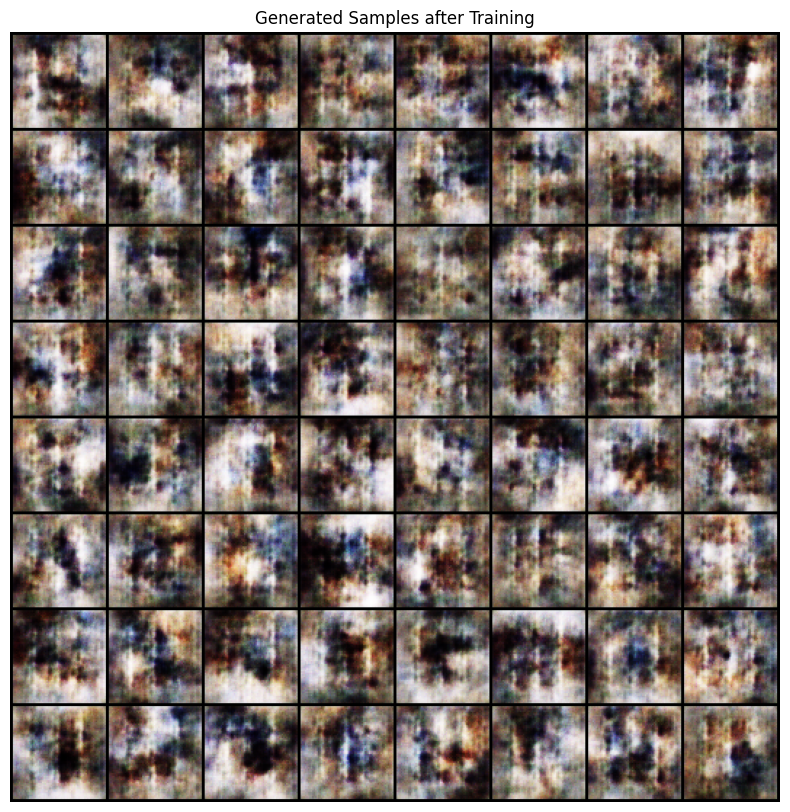

In [60]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

# Generate new random noise for inference
num_samples = 64  # Number of images to generate
inference_noise = torch.randn(num_samples, z_dim, 1, 1, device=device)

# Generate images using the trained Generator
netG.eval()  # Set the generator to evaluation mode
with torch.no_grad():
    generated_images = netG(inference_noise).detach().cpu()

# Visualize the generated images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Samples after Training")
plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()
